In [1]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

## Import preprocessed data

In [2]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [3]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x1_Widow,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [4]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x0_2nd Cycle', 'x0_Graduation', 'x0_Master', 'x0_PhD', 'x1_Married',
       'x1_Single', 'x1_Together', 'x1_Widow', 'x2_M', 'x3_1.0',
       'x4_Kind of OK', 'x4_Meh...', 'x4_OK nice!', 'x4_Take my money!!',
       'PC0', 'PC1', 'PC2'],
      dtype='object')

In [5]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

In [6]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

# Density Based Clustering
## Mean Shift Clustering
What is Mean-shift clustering? How does it work?

Single seed             |  Multiple seeds
:-------------------------:|:-------------------------:
![](../figures/mean_shift_0.gif)  |  ![](../figures/mean_shift_tutorial.gif)
 
### Characteristics:
- No need to define number of clusters apriori
- Can detect clusters of any shape
- Robust to outliers
- Depends on the bandwidth hyperparameter (but there's a way to estimate it)
- **Main drawback**: Poor scalability (on both the algorithm and in estimating the bandwidth)

In [12]:
# The following bandwidth can be automatically detected using (we need to set quantile though)
# Based on distance to nearest neighbors for all observations
bandwidth = estimate_bandwidth(df[metric_features], random_state=1, n_jobs=-1 , quantile=.055)
# TO-DO: manipulate the quantile value such that we obtain a small enough bandwidth
bandwidth

2.275657403691861

In [13]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
# TO-DO: explore the MeanShift class and obtain the cluster labels
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms_labels = ms.fit_predict(df[metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 6


In [14]:
from collections import Counter
Counter(ms_labels)

Counter({0: 6973, 5: 427, 1: 501, 3: 209, 4: 167, 2: 540})

In [15]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,ms_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0


In [16]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2568


## DBSCAN (Density-based spatial clustering of applications with noise)
What is DBSCAN clustering? How does it work?

DBSCAN animation            |  Core, border and noise
:-------------------------:|:-------------------------:
![](../figures/dbscan.gif)  |  ![](../figures/dbscan.jpg)


### Characteristics:
- No need to define number of clusters apriori
- Resistant to noise and outliers
- Can identify outliers
- Can handle clusters of different shapes and sizes
- Depends highly on the epsilon hyperparameter and it can be hard to tune
- Does not work well with clusters of varying densities

In [19]:
# Perform DBSCAN clustering
# TO-DO: explore the DBSCAN class and obtain the cluster labels
dbscan = DBSCAN(eps=.5, min_samples=5,n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 37


In [21]:
#Counter(dbscan_labels)

### Defining eps and min_samples:
- **MinPts**: As a rule of thumb, **minPts = 2 x dim** can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates.

- **ε**: The value for ε can then be chosen by using a **k-distance graph**, plotting the distance to the kth (k = minPts - 1) nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an **"elbow"**: if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. **The assumption is that for points in a cluster, their k nearest neighbors are at roughly the same distance**. Noise points have their k-th nearest neighbors at farther distance

In [22]:
len(metric_features)
#best practice is: min number of observations per feature - 1 

10

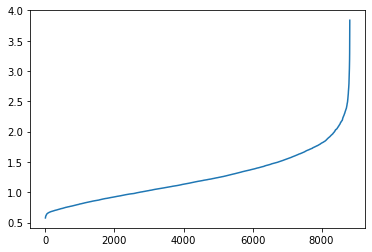

In [23]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=19)
neigh.fit(df[metric_features])
distances, _ = neigh.kneighbors(df[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [26]:
# Perform DBSCAN clustering
# TO-DO: Re-cluster the data using the defined hyperparameters
dbscan = DBSCAN(eps=1.75, min_samples=20,n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [27]:
#its a good way to find outliers, but not a great way to find clusters 
Counter(dbscan_labels)

Counter({0: 8568, -1: 249})

In [28]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0


In [29]:
# Detecting noise (potential outliers)
# TO-DO: can we identify the noisy data? 
df_concat[df_concat['dbscan_labels']==-1]

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
15,1.550018,2.199138,0.657173,-1.400205,-0.790228,0.502272,1.075978,3.214455,-1.041124,1.723881,-1
18,0.705467,-0.640275,-0.273146,-1.704776,-0.379855,-1.165068,3.976684,3.877621,-1.473995,-0.707594,-1
77,-0.409958,0.733635,1.255236,-1.226165,-0.653437,1.852024,2.381296,-0.897173,1.339671,2.022158,-1
148,0.053647,0.642041,-0.007341,-0.530003,2.492751,-1.244465,1.366049,0.031259,0.528037,1.301679,-1
154,-1.363078,-1.189839,1.554267,-1.791796,1.261634,-1.403260,1.656119,5.071320,-0.067162,-0.985227,-1
...,...,...,...,...,...,...,...,...,...,...,...
8688,-1.258253,-1.006651,1.587493,-1.791796,3.860658,0.978655,-0.229339,0.296525,1.177344,-0.986057,-1
8691,0.751567,0.458853,-0.073792,-1.313185,2.219169,-0.768082,0.350802,2.816556,-0.932906,0.350730,-1
8773,0.356305,-1.373027,1.587493,-0.399472,-0.516646,-0.291699,3.106472,-0.631907,0.636254,-0.994125,-1
8803,0.687849,0.550447,-1.568948,-1.400205,4.407821,-0.291699,-0.519409,0.959691,-1.311668,0.033114,-1


In [32]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat[df_concat['dbscan_labels']!=-1]# TO-DO: Remove the noisy data (we don't want to include it in the R² computation. Why?) 
sst = get_ss(df_nonoise)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0000


- Why did the DBSCAN gave us just one cluster?
- What can we do with the noisy data?

## GMM (Gaussian Mixture Model )
What is GMM? How does it work?
![](../figures/gmm.gif)

--- 

$$\mathcal{p(\vec{x})} \ = \ \sum_{i=1}^K \phi_i \mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \tag{eq1}$$
$$\mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \ = \ \frac{1}{\sqrt{{(2\pi)}^{K}|\Sigma_i|}}e^{-\frac{1}{2} (\vec{x} - \vec{\mu_i})^T \Sigma_i^{-1} (\vec{x} - \vec{\mu_i})} \tag{eq2}$$
$$\sum_{i=1}^K \phi_i \ = \ 1 \tag{eq3}$$

, where:
- $\phi_i$ is the component weight (scalar) for Component $i$ (probability of an observation being generated by Component $i$)
- $\vec{\mu_i}$ is the mean vector for Component $i$,
- $\Sigma_i$ is the Covariance matrix for Component $i$

---

- **(eq1)** gives the probability of a point $x$ given the estimated Gaussian mixture
- **(eq2)** is the probability density function of a multivariate Gaussian with mean $\vec{\mu_i}$ and covariance $\Sigma_i$
- **(eq3)** states that the sum of the component weights is 1, such that the total probability distribution normalizes to 1

### Characteristics:
- Assumes the data is generated from a mixture of finite number of Gaussian distributions with unknown parameters
- Use the EM (Expectation Maximization algorithm) to estimate the parameters
- Provides a probability of each observation belonging to each cluster
- Advantages over K-Means:
    - Can deal with spherical and elipsoid cluster shapes
    - Number of components needs to be defined apriori

In [33]:
# Performing GMM clustering
# TO-DO: explore the GaussianMixture class and obtain the cluster labels and the cluster probabilities
gmm = GaussianMixture(n_components=4,n_init=10,init_params='kmeans',random_state=9)
gmm_labels = gmm.fit_predict(df[metric_features])
labels_proba = gmm.predict_proba(df[metric_features])

In [34]:
gmm_labels, labels_proba

(array([1, 1, 2, ..., 3, 1, 0], dtype=int64),
 array([[3.03323346e-013, 1.00000000e+000, 8.77681222e-034,
         1.06585966e-022],
        [6.52588351e-009, 9.99999993e-001, 2.45640665e-086,
         2.93219842e-054],
        [4.34388726e-162, 1.65942946e-015, 1.00000000e+000,
         1.26244758e-019],
        ...,
        [9.49704291e-009, 3.08010813e-023, 8.08876582e-002,
         9.19112332e-001],
        [2.56475303e-029, 9.99667625e-001, 1.61295765e-013,
         3.32374968e-004],
        [9.36771030e-001, 6.32289700e-002, 7.03303673e-160,
         4.53710764e-024]]))

**Let's look at the estimated parameters:**

In [35]:
# The estimated component weights
gmm.weights_

array([0.19056245, 0.33573405, 0.22324086, 0.25046264])

In [36]:
# The estimated mean vectors of the Components
gmm.means_

array([[ 0.21128311,  0.28525367, -0.05961622,  1.24696862, -0.74404013,
        -1.0050323 , -0.75556642, -0.71880209,  0.34778967,  0.78361992],
       [ 0.97539549,  0.94396949, -0.05327009, -0.28611798,  0.1233094 ,
         0.33348291,  0.12544242,  0.08199964, -1.06946684,  0.49884501],
       [-1.10304781, -0.91550901,  0.10629403, -1.04234973,  0.9316929 ,
         0.29434537,  0.91534146,  0.9465233 ,  0.68134282, -0.83563577],
       [-0.4850654 , -0.66637609,  0.02202334,  0.36384347, -0.42962485,
         0.05529744, -0.40914011, -0.40667166,  0.56166947, -0.52007653]])

In [37]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

(4, 10, 10)

### Defining covariance_type:
This hyperparameter controls the **degrees of freedom** in the shape of each cluster The more degrees of freedom we have the more complex shapes the model can fit and the more computationally expensive the model will be.

![](../figures/gmm_covariance.png)

- `covariance_type="tied"` makes all components share the same general covariance matrix

### Defining n_components:

**AIC**: estimates the relative amount of information lost by a model used to represent the data-generation process. The smaller the better.

**BIC**: similar to AIC but penalizes more complex models (i.e. favors simpler models). The smaller the better.

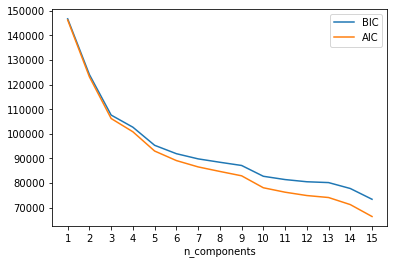

In [38]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[metric_features])
          for n in n_components]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
#we want the lowest values here:
bic_values = [gmm.bic(df[metric_features]) for gmm in models]
aic_values = [gmm.aic(df[metric_features]) for gmm in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [ ]:
#number of componendts to keep: 3-5

**Note**: the AIC and BIC measures can also be used to select diferent hyperparameters such as the covariance_type

In [39]:
# Performing GMM clustering
# TO-DO: Re-cluster the data using the defined hyperparameters
gmm = GaussianMixture(5, covariance_type='full', n_init=10, random_state=1)
gmm_labels = gmm.fit_predict(df[metric_features])

In [40]:
Counter(gmm_labels)

Counter({2: 1645, 4: 2140, 1: 1595, 0: 1486, 3: 1951})

In [42]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.groupby('gmm_labels').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
gmm_labels,,,,,,,,,,
0,0.614945,0.837741,0.009339,0.862058,-0.524379,-0.656574,-0.556400,-0.518374,-0.092687,1.403390
1,0.071543,-0.034836,-0.113392,-0.393198,0.319793,0.135751,0.391630,0.307169,0.014018,0.159690
2,1.260812,1.264935,-0.046565,-0.474431,0.104442,0.723523,0.101994,0.045450,-1.517677,0.268779
3,-0.353446,-0.585628,-0.008993,0.972201,-0.688844,-0.602410,-0.685260,-0.666034,0.566947,-0.423467
4,-1.127281,-0.994196,0.122022,-0.827193,0.673497,0.347782,0.640805,0.703288,0.703663,-0.914065


In [43]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.4354


# Clustering by Perspectives
- Demographic Perspective:
- Value Perspective:
- Product Perspective:

## Merging the Perspectives
- How can we merge different cluster solutions?